# UTAS-Polis Visualization

Polis-like Visualization of UTAS data

derived from https://github.com/compdemocracy/analysis-python/blob/main/notebooks/american-assembly-specific/american-assembly-representative-groups-and-comments.ipynb


## Install necessary libraries

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
import json
import matplotlib_fontja

matplotlib_fontja.japanize()

## Data Loading

Description of data loading process.

In [45]:
# Load the CSV file
data = pd.read_csv("2022UTASP20220720.csv", encoding="SJIS")
print(data.shape)
assert data.shape == (668, 111)

(668, 111)


In [ ]:
# Q3, Q4, Q5で始まる列を抽出
# Extract columns starting with Q3, Q4, or Q5
data_NAME = data.filter(like="NAME", axis=1)
data_PARTY = data.filter(like="PARTY", axis=1)
data_Q3 = data.filter(like="Q3", axis=1)
data_Q4 = data.filter(like="Q4", axis=1)
data_Q5 = data.filter(like="Q5", axis=1)

# 結合 / concatenate
matrix = pd.concat([data_Q3, data_Q4, data_Q5], axis=1)

print(matrix.shape)
assert matrix.shape == (668, 42)


(668, 42)


In [ ]:
# 値が66または99の時、欠損値にする
# Replace values 66 and 99 with missing values  
matrix = matrix.replace(66, pd.NA)
matrix = matrix.replace(99, pd.NA)

# 欠損してない値が3つ以上ない行を削除
# Drop rows with fewer than 3 non-missing values  
matrix = matrix.dropna(thresh=3)
print(matrix.shape)
assert matrix.shape == (592, 42)

(592, 42)


In [ ]:
BINARIZE_TYPE = 1
if BINARIZE_TYPE == 1:
    # 1, 2を+1, 3を0, 4, 5を-1にする
    # Convert 1 and 2 to +1, 3 to 0, and 4 and 5 to -1  
    matrix = matrix.replace(2, 1)
    matrix = matrix.replace(3, 0)
    matrix = matrix.replace(4, -1)
    matrix = matrix.replace(5, -1)
elif BINARIZE_TYPE == 2:
    # 2, 3, 4を0にする
    # Convert 2, 3, and 4 to 0
    matrix = matrix.replace(2, 0)
    matrix = matrix.replace(3, 0)
    matrix = matrix.replace(4, 0)
    matrix = matrix.replace(5, -1)

In [49]:
readable = {}
info = json.load(open("info.json", "r"))
for key in info:
    items = info[key]["項目"]
    for item in items:
        i = item["番号"]
        readable[f"{key}_{i}"] = item["質問"]

In [50]:
political_parties = {
    1: "自民党",
    2: "立憲民主党",
    3: "公明党",
    4: "日本維新の会",
    5: "国民民主党",
    6: "共産党",
    7: "社民党",
    8: "れいわ新選組",
    9: "NHK党",
    10: "参政党",
    11: "諸派",
    12: "無所属候補",
}
parties_letter = {
    "自民党": "自",
    "立憲民主党": "立",
    "公明党": "公",
    "日本維新の会": "維",
    "国民民主党": "国",
    "共産党": "共",
    "社民党": "社",
    "れいわ新選組": "れ",
    "NHK党": "N",
    "参政党": "参",
    "諸派": "諸",
    "無所属候補": "無",
}

In [51]:
party_colors = {
    1: "#007AC0",  # "自民党",
    2: "#004098",  # "立憲民主党",
    3: "#F6C51D",  # "公明党",
    4: "#7FBD00",  # "日本維新の会",
    5: "#FFD700",  # "国民民主党",
    6: "#E60012",  # "共産党",
    7: "#FF4500",  # "社民党",
    8: "#FF1493",  # "れいわ新選組",
    9: "#6A1B9A",  # "NHK党",
    10: "#800080",  # "参政党",
    11: "#808080",  # "諸派",  
    12: "#808080",  # "無所属候補",

}
colors = [party_colors[p] for p in range(1, 13)]


## main Polis algorithm

In [ ]:
pd.set_option('future.no_silent_downcasting', True)
non_na_counts = matrix.count(axis=1)  # 欠損していない値の数 / The number of non-missing values
matrix = matrix.fillna(matrix.mean(axis=0)).infer_objects()

### Step 1 - get PCA clusters

In [53]:
def polis_pca(dataframe, components):
    pca = PCA(n_components=components)  ## pca is apparently different, it wants
    pca = pca.fit(dataframe.T)  ## .T transposes the matrix (flips it)
    coords = pca.components_.T  ## isolate the coordinates and flip
    explained_variance = pca.explained_variance_ratio_

    return pca, coords, explained_variance

pca, embedding, explained_variance = polis_pca(matrix, 2)
print("Explained variance:", explained_variance)


Explained variance: [0.29123858 0.18823937]


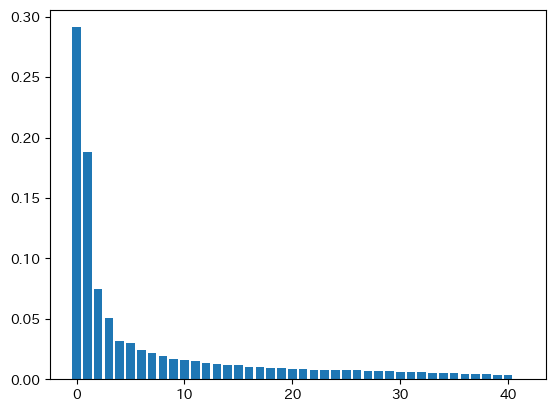

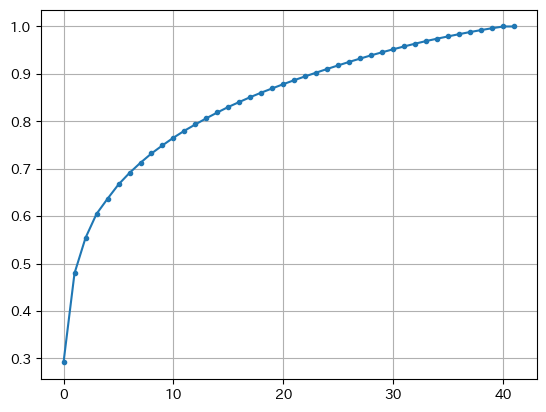

In [ ]:
# nishio: more Explained variances
def plot_explained_variances(dataframe):
    pca = PCA()
    pca = pca.fit(dataframe.T)
    explained_variance = pca.explained_variance_ratio_
    plt.bar(range(len(explained_variance)), explained_variance)
    plt.show()
    plt.plot(np.cumsum(explained_variance), marker=".")
    plt.grid()
    plt.show()

plot_explained_variances(matrix)


In [55]:
DO_POLIS_SCALING = True
if DO_POLIS_SCALING:
    num_comments = matrix.shape[1]
    scaling_coeffs = np.sqrt(num_comments / non_na_counts).values
    # Reshape scaling_coeffs to match the shape of embedding (needed for broadcasting)
    scaling_coeffs = scaling_coeffs.reshape(-1, 1)

    embedding -= embedding.mean(axis=0)
    embedding = embedding * scaling_coeffs


### Step 2 - K-means

In [ ]:
# Step 2 - K-means with K=100 (DIGEST) or K=668 (FULL)
TO_USE_FULL_DATA = False

# given a dataframe, returns the found lables/clusters and the corresponding centers
def polis_kmeans_(dataframe, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(dataframe)

    return kmeans.labels_, kmeans.cluster_centers_


n_voters = len(matrix)
if TO_USE_FULL_DATA:
    n_clusters = n_voters
else:
    n_clusters = min(100, n_voters)
print("Running K-means with K=" + str(n_clusters))
cluster_mappings, centers = polis_kmeans_(embedding, n_clusters=n_clusters)

# cluster_mappingsは各行がどのクラスタに所属するかを示す
# cluster_mappings indicates which cluster each row belongs to.  

Running K-means with K=100


### Step 3 - find optimal K

In [57]:
# Step 3 - find optimal K
from sklearn.metrics import silhouette_score

FIXED_CLUSTER_SIZE = None

if FIXED_CLUSTER_SIZE is None:
    TO_FIND_OPTIMAL_K = True
else:
    TO_FIND_OPTIMAL_K = False

if TO_FIND_OPTIMAL_K:
    K_RANGE = range(2, 6)

    K_star = 0
    silhoutte_star = -np.inf

    for K in K_RANGE:
        clusters_K, _ = polis_kmeans_(centers, n_clusters=K)
        silhouette_K = silhouette_score(centers, clusters_K)
        print(f"{K=}, {silhouette_K=}")
        if silhouette_K >= silhoutte_star:
            K_star = K
            silhoutte_star = silhouette_K
            clusters_K_star = clusters_K
    print(f"Optimal clusters for K={K_star}")
else:
    K_star = FIXED_CLUSTER_SIZE
    clusters_K_star = cluster_mappings

K=2, silhouette_K=0.4965191384460503
K=3, silhouette_K=0.3790245348726443
K=4, silhouette_K=0.3698064088526268
K=5, silhouette_K=0.3422744433876885
Optimal clusters for K=2


### Usual Polis Visualization


In [58]:
data_PARTY_filtered = data_PARTY.loc[matrix.index]
data_NAME_filtered = data_NAME.loc[matrix.index]

label=0, len(points)=55
label=1, len(points)=45


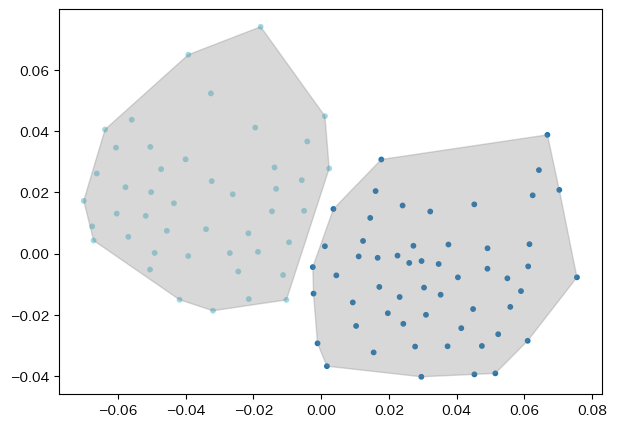

In [59]:
def plot_embedding_with_clusters(embedding_, labels_, TO_DRAW_CLUSTER_BOUNDS=True):
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.sca(ax)

    # Create a marker map for the parties
    unique_parties = data_PARTY_filtered["PARTY"].unique()

    colormap = plt.get_cmap("tab20", len(unique_parties))
    ax.scatter(
        x=embedding_[:, 0], y=embedding_[:, 1], c=labels_, cmap=colormap, s=10
    )
    
    if TO_DRAW_CLUSTER_BOUNDS:
        unique_labels = set(labels_)

        # plot convex hull for each cluster
        for label in unique_labels:
            # get points in this cluster
            points = embedding_[labels_ == label]
            print(f"{label=}, {len(points)=}")
            if len(points) < 2:
                continue
            # compute convex hull
            hull = ConvexHull(points)

            # get coordinates of the hull vertices
            hull_points = points[hull.vertices, :]

            # create a polygon patch and add it to the plot
            polygon = patches.Polygon(
                hull_points, fill=True, color="gray", alpha=0.3, edgecolor=None
            )
            ax.add_patch(polygon)

    plt.show()

if not TO_USE_FULL_DATA:
    plot_embedding_with_clusters(centers, clusters_K_star)

### Step 4 - assign each voter to "optimal" cluster

In [60]:
# Step 4 - assign each voter to "optimal" cluster
# print(len(cluster_mappings), n_voters, len(clusters_K_star))
clusters_star = np.zeros(len(cluster_mappings))
for k in range(len(clusters_K_star)):
    # find all indices with clusters k and assign them new star label
    clusters_star[np.where(cluster_mappings == k)] = clusters_K_star[k]

clusters_star[:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])

### Show significant comments
#### Step 1: Calculate N_v(g,c), N(g,c), and P_v(g,c)

In [ ]:
# 変数名は論文参照 Paper: https://www.e-revistes.uji.es/index.php/recerca/article/view/5516/6558
# Refer to the paper for variable names: Paper: https://www.e-revistes.uji.es/index.php/recerca/article/view/5516/6558  

# ここからclusters_star == g かどうかで分けて各コメントのp-valueを計算する
# From here, calculate the p-value for each comment based on whether clusters_star == g.  

# mapping of integer index to column name
statements_all_in = matrix.columns

# Step 1: Calculate N_v(g,c), N(g,c), and P_v(g,c)
# N_v(g,c)は、グループgでコメントcに対して投票値vを付けた人数
# N(g,c)は、グループgでコメントcに+1か-1で投票した人数の合計
# P_v(g,c)は、グループgでコメントcに投票値vを付けた割合（スムージングあり）
# N_v(g,c) is the number of people in group g who gave the voting value v to comment c.  
# N(g,c) is the total number of people in group g who voted +1 or -1 on comment c.  
# P_v(g,c) is the proportion of votes with value v given to comment c in group g (with smoothing applied). 
N_groups = clusters_K_star.max() + 1
N_comments = len(statements_all_in)
N_v_g_c = np.zeros([3, N_groups, N_comments])  # create N matrix
P_v_g_c = np.zeros([3, N_groups, N_comments])
N_g_c = np.zeros([N_groups, N_comments])
v_values = [-1, 0, 1]

for g in range(N_groups):
    # get indices of cluster g; caution_ idx != participant id
    idx_g = np.where(clusters_star == g)[0]
    # print("idx_g", idx_g)
    for c in range(N_comments):
        comment = statements_all_in[c]  # comment id
        # print("comment", comment)

        # data frame: [participants of group g,comment c],
        # gの中にいる人のcomment cの投票値を取得
        # Retrieve the voting value for comment c from people within group g.
        df_c = matrix[comment].iloc[idx_g]
        # print("df_c", df_c)

        for v in range(3):
            v_value = v_values[v]
            # counts all v_value votes in data frame df_c
            # N_v(g,c)は、グループgでコメントcに対して投票値vを付けた人数
            # N_v(g,c) is the number of people in group g who gave the voting value v to comment c.  
            N_v_g_c[v, g, c] = (df_c == v_value).sum()
        # print("N_v_g_c", N_v_g_c)

        # total votes corresponds to votes with +1 or -1
        # N(g,c)は、グループgでコメントcに+1か-1で投票した人数の合計
        # N(g,c) is the total number of people in group g who voted +1 or -1 on comment c.  
        N_g_c[g, c] = N_v_g_c[0, g, c] + N_v_g_c[2, g, c]

        # P_v(g,c)は、グループgでコメントcに投票値vを付けた割合（スムージングあり）
        # このスムージングとは、ベイズ推定の文脈でベルヌーイ分布の共役事前分布はベータ分布であることを利用して、MAP推定をしたものに相当する
        # nishio: ここは v in [0, 2] の方が筋が通るのでは(機能に影響はないが) その場合はこのグループが賛成/反対をする確率の推定になる
        # P_v(g,c) is the proportion of votes with value v given to comment c in group g (with smoothing applied).  
        # This smoothing corresponds to a MAP estimation utilizing the fact that the conjugate prior for a Bernoulli distribution in the Bayesian context is a Beta distribution.  
        # nishio: Wouldn't it make more sense if v is in [0, 2]? (This does not affect functionality, but in that case, it would estimate the probability of this group agreeing/disagreeing).  

        for v in range(3):
            P_v_g_c[v, g, c] = (1 + N_v_g_c[v, g, c]) / (2 + N_g_c[g, c])


### Step2: calculate R_v(g,c)

In [ ]:
# Step2: calculate R_v(g,c)
# 代表性尺度 (see Paper)
# R_v(g,c)は、グループg以外でのP_v(g,c)の合計に対するP_v(g,c)の比率
# R_v(g,c) は、グループ g 以外の全グループにおける投票値 v の割合の合計に対する、グループ g での投票値 v の割合の比率を表します。
# Representativeness Scale (see Paper)  
# R_v(g,c) is the ratio of P_v(g,c) to the total P_v(g,c) across all groups except group g.  
# R_v(g,c) represents the ratio of the proportion of voting value v in group g to the total proportion of voting value v across all groups except group g.  

R_v_g_c = np.zeros([3, N_groups, N_comments])
for g in range(N_groups):
    for c in range(N_comments):
        for v in range(3):
            # np.delete neglects all entries with group g
            R_v_g_c[v, g, c] = (
                P_v_g_c[v, g, c] / np.delete(P_v_g_c[v, :, c], g, 0).sum()
            )


In [ ]:
# Fisherの正確確率検定 / Fisher's exact test
import scipy.stats as stats
from scipy.stats import hypergeom

v_values = [-1, 0, 1]
p_values = np.zeros([N_groups, N_comments, 3])
for g in range(N_groups):
    idx_g = np.where(clusters_star == g)[
        0
    ]  # get indices of cluster g; caution_ idx != participant id
    idx_g_not = np.where(clusters_star != g)[0]  # get indices of rest
    for c in range(N_comments):
        comment = statements_all_in[c]  # comment id

        for v in range(3):
            v_value = v_values[v]

            # totol number of v votes in comment c
            N_v = (matrix[comment] == v_value).sum()

            # total number of votes =  number of participants
            N_total = (matrix[comment]).count()
            N_rest = N_total - N_v

            # get data frame of group g for comment c
            df_c = matrix[comment].iloc[idx_g]
            # number of v votes in group g
            N_v_in_g = (df_c == v_value).sum()
            # number of votes in group g
            N_g = (df_c).count()

            [M, n, N] = [
                N_rest + N_v,
                N_v,
                N_g,
            ]  # hypergeometric distribution parameters https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
            x = range(N_v_in_g - 1, N_g + 1)
            prb = hypergeom.pmf(
                x, M, n, N
            ).sum()  # calculates P(X>=N_v_in_g), i.e. p-value.
            p_values[g, c, v] = prb * R_v_g_c[v, g, c]


In [64]:
# Compute total vote counts for each comment
total_vote_counts = np.zeros([3, N_comments])
for v in range(3):
    v_value = v_values[v]
    for c in range(N_comments):
        comment = statements_all_in[c]
        total_vote_counts[v, c] = (matrix[comment] == v_value).sum()


In [65]:
## Lets print the most significant comments for each group!
for g in range(N_groups):
    # print("p_value", p_values[g, :, 0])
    idx_ = np.argsort(p_values[g, :, 0])  # take only the significant comments
    print("----------------------------------")
    print("significant comments for group ", g)
    print("----------------------------------")
    for i in range(5):
        print(" ")
        # print(df_comments["comment-body"][idx_[i]])
        c = idx_[i]
        q = statements_all_in[c]
        q = q.replace(".0", "")
        print("comment", c, ":", q + readable.get(q, ""))
        a2 = N_v_g_c[2, g, c]
        print("Count of +1 votes in group: ", a2)
        a1 = N_v_g_c[1, g, c]
        print("Count of 0 votes in group: ", a1)
        a0 = N_v_g_c[0, g, c]
        print("Count of -1 votes in group: ", a0)
        s = a2 + a1 + a0
        print(f"agree: {a2/s*100:.1f}% neutral: {a1/s*100:.1f}% disagree: {a0/s*100:.1f}%")
        print(" ")

        b2 = total_vote_counts[2, c] - N_v_g_c[2, g, c]
        print(
            "Count of +1 votes outside group: ",
            b2,
        )
        b1 = total_vote_counts[1, c] - N_v_g_c[1, g, c]
        print(
            "Count of 0 votes outside group: ",
            b1,
        )
        b0 = total_vote_counts[0, c] - N_v_g_c[0, g, c]
        print(
            "Count of -1 votes outside group: ",
            b0,
        )
        s = b2 + b1 + b0
        print(f"agree: {b2/s*100:.1f}% neutral: {b1/s*100:.1f}% disagree: {b0/s*100:.1f}%")

        print(" ")
        print("pvalue: ", p_values[g, c, 0])
        if p_values[g, c, 0] >= 0.05:
            break

    print("total votes in group: ", N_g_c[g, c])
print(n_voters)


----------------------------------
significant comments for group  0
----------------------------------
 
comment 22 : Q4_18永住外国人の地方参政権を認めるべきだ
Count of +1 votes in group:  8.0
Count of 0 votes in group:  35.0
Count of -1 votes in group:  249.0
agree: 2.7% neutral: 12.0% disagree: 85.3%
 
Count of +1 votes outside group:  155.0
Count of 0 votes outside group:  41.0
Count of -1 votes outside group:  18.0
agree: 72.4% neutral: 19.2% disagree: 8.4%
 
pvalue:  6.194874817104186e-66
 
comment 37 : Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
Count of +1 votes in group:  17.0
Count of 0 votes in group:  112.0
Count of -1 votes in group:  202.0
agree: 5.1% neutral: 33.8% disagree: 61.0%
 
Count of +1 votes outside group:  176.0
Count of 0 votes outside group:  58.0
Count of -1 votes outside group:  23.0
agree: 68.5% neutral: 22.6% disagree: 8.9%
 
pvalue:  1.151133263977603e-39
 
comment 31 : Q4_27国会議員の議席や候補者の一定割合を女性に割り当てるクオータ制を導入すべきだ
Count of +1 votes in group:  62.0
Count of 0 votes in gr

## Visualization of all participants

2つのクラスタに分かれただけでは面白くないことと、元データが政治家による記名のアンケート結果であることを踏まえて、すべての政治家意見ベクトルを所属している党のアノテーション付きで可視化する

Considering that splitting into only two clusters is not interesting and the original data consists of named survey results from politicians, visualize all politicians' opinion vectors with annotations indicating their affiliated parties.

In [66]:
# Step 2 - K-means with K=100 (DIGEST) or K=668 (FULL)
TO_USE_FULL_DATA = True

n_voters = len(matrix)
if TO_USE_FULL_DATA:
    n_clusters = n_voters
else:
    n_clusters = min(100, n_voters)
print("Running K-means with K=" + str(n_clusters))
cluster_mappings, centers = polis_kmeans_(embedding, n_clusters=n_clusters)

# expected warning: ConvergenceWarning: Number of distinct clusters (526) found smaller than n_clusters (592). Possibly due to duplicate points in X.


Running K-means with K=592


/Users/nishio/UTAS-UMAP/venv/lib/python3.10/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (518) found smaller than n_clusters (592). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


上記警告はデータ点の中に全く同一の意見ベクトルが含まれていることによる

The above warning is due to the presence of identical opinion vectors among the data points.

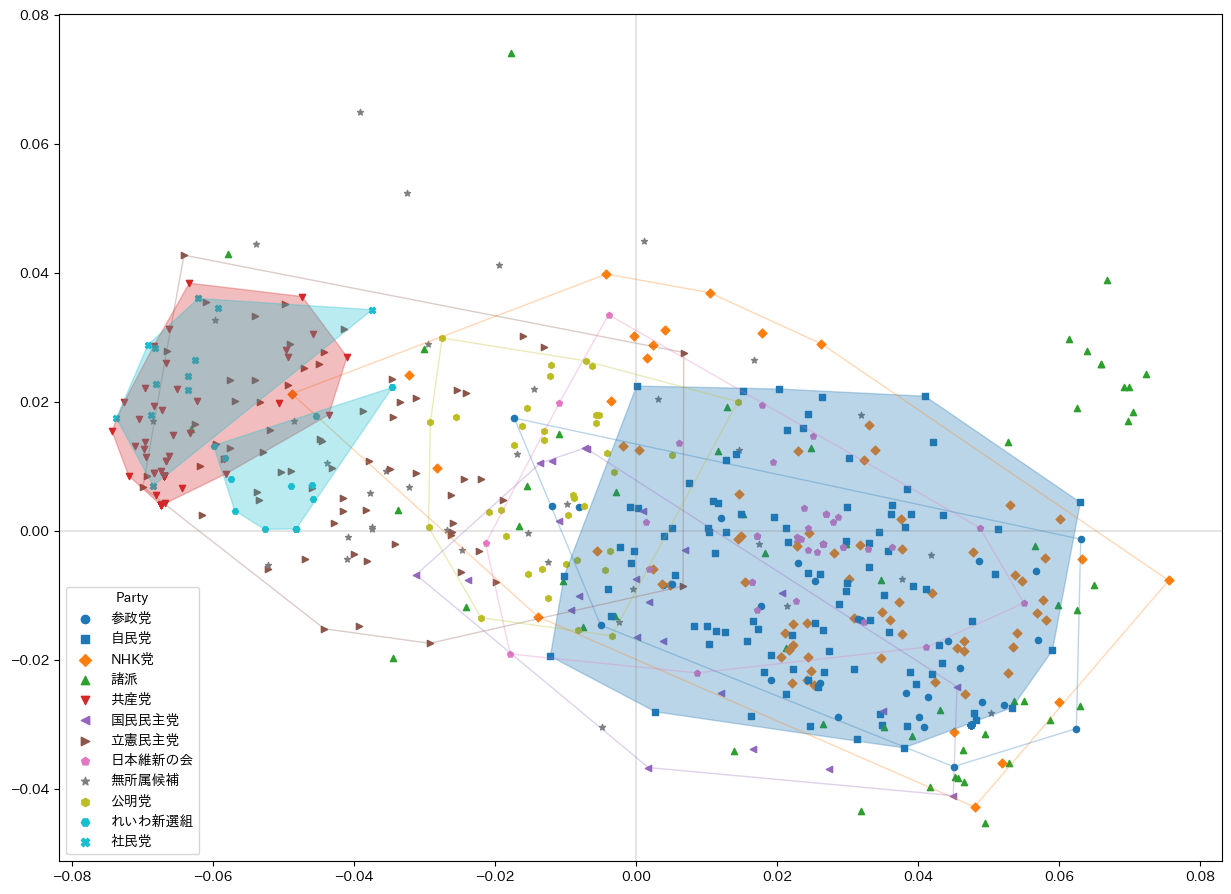

In [67]:
def plot_embedding_with_clusters(embedding_, labels_):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.sca(ax)

    # Create a marker map for the parties
    unique_parties = data_PARTY_filtered["PARTY"].unique()
    markers = ["o", "s", "D", "^", "v", "<", ">", "p", "*", "h", "H", "X", "d"]
    party_to_marker = {
        party: markers[i % len(markers)] for i, party in enumerate(unique_parties)
    }

    # Raw data plot
    colormap = plt.cm.tab10(np.linspace(0, 1, len(unique_parties)))
    party_to_color = {party: colormap[i] for i, party in enumerate(unique_parties)}

    # Plot each point with the marker corresponding to its party
    # Should not use `embedding_` because it is suffled in the process of kMeans, use `embedding` instead.
    for i in range(len(matrix.index)):
        index = matrix.index[i]
        party = data_PARTY_filtered.loc[index, "PARTY"]
        # print(index, party)
        marker = party_to_marker[party]
        color = party_to_color[party]
        ax.scatter(embedding[i, 0], embedding[i, 1], s=20, marker=marker, color=color)

        if not "plot name":
            label = str(index + 1) + data_NAME_filtered.loc[index, "NAME"]
            plt.text(embedding[i, 0], embedding[i, 1], label, fontsize=8)

    # show legend to show which marker is which party
    for party in unique_parties:
        ax.scatter(
            [],
            [],
            marker=party_to_marker[party],
            color=party_to_color[party],
            label=political_parties[party],
        )
    ax.legend(title="Party")

    ax.axhline(0, color="gray", linewidth=0.3)
    ax.axvline(0, color="gray", linewidth=0.3)

    # convex hull
    if "draw party bound":
        # plot convex hull for each party
        for label in unique_parties:
            if label in [11, 12]:
                continue

            # get points in this cluster
            points = []

            for i in range(len(matrix.index)):
                index = matrix.index[i]
                party = data_PARTY_filtered.loc[index, "PARTY"]
                if party == label:
                    points.append(embedding[i])
            # convert points(list) to np.array
            points = np.array(points)

            if len(points) < 2:
                continue
            # compute convex hull
            hull = ConvexHull(points)

            # get coordinates of the hull vertices
            hull_points = points[hull.vertices, :]

            # create a polygon patch and add it to the plot
            fill = True if label in [1, 6, 7, 8] else False
            # fill = True if label in [2, 3, 4, 5] else False
            polygon = patches.Polygon(
                hull_points,
                fill=fill,
                facecolor=party_to_color[label],
                alpha=0.3,
                edgecolor=party_to_color[label],
            )
            ax.add_patch(polygon)

    plt.show()

plot_embedding_with_clusters(centers, clusters_K_star)

## Explanation of PCA Principal Axes
PCA　主成分軸の解説

In [ ]:
# PCA成分の取得 / Retrieving PCA Components
matrix_centered = matrix - matrix.mean(axis=0)  # 平均中心化 / Mean Centering

for i in range(2):
    pc1 = pca.components_[i]  # 第i主成分ベクトル / i-th Principal Component Vector
    print(f"# PC{i+1}")
    buf = []
    for col in matrix.columns:
        question_vector = matrix_centered[col]
        # contributions[col] = np.dot(question_vector, pc1)
        c = np.dot(question_vector, pc1)
        buf.append((abs(c), col, c, readable.get(col, col)))
        # print(f"{col}: {c:.2f}: {readable.get(col, col)}")
    buf.sort(reverse=True)
    for b in buf[:10]:
        print(f"{b[1]}: {b[2]:.2f}: {b[3]}")
    print()

# PC1
Q4_2: 18.18: 他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
Q4_18: -15.63: 永住外国人の地方参政権を認めるべきだ
Q4_1: 15.40: 日本の防衛力はもっと強化すべきだ
Q4_6: 15.15: 首相には靖国神社に参拝してほしい
Q5_6: -14.52: いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
Q4_27: -14.44: 国会議員の議席や候補者の一定割合を女性に割り当てるクオータ制を導入すべきだ
Q4_5: -14.37: 非核三原則を堅持すべきだ
Q4_7: 14.18: 沖縄県の普天間基地の辺野古移設はやむをえない
Q4_20: 13.01: 福島第一原発の処理水の海洋放出はやむをえない
Q4_24: -12.98: 夫婦が望む場合には、結婚後も夫婦がそれぞれ結婚前の名字を称することを、法律で認めるべきだ

# PC2
Q4_2: -5.10: 他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
Q4_18: 5.04: 永住外国人の地方参政権を認めるべきだ
Q5_7: -4.84: 国債は安定的に消化されており、財政赤字を心配する必要はない / 財政赤字は危機的水準であるので、国債発行を抑制すべきだ
Q4_6: -4.73: 首相には靖国神社に参拝してほしい
Q4_1: -4.56: 日本の防衛力はもっと強化すべきだ
Q4_5: 4.45: 非核三原則を堅持すべきだ
Q3_5: -4.39: 日本銀行は国債の買入れなど量的金融緩和政策を続ける
Q4_3: -4.28: 北朝鮮に対しては対話よりも圧力を優先すべきだ
Q5_6: 4.23: いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
Q5_2: -4.14: 日本にとって中国は脅威である / 日本にとって中国はパートナーである

